# Fairness Analysis 

In [31]:
#biasAttribute = 'V1_sex'
biasAttribute = 'V4_area_origin'

#### Load dependencies

In [32]:
import torch

import tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from src.data.dataloader import CatalanJuvenileJustice
from src.models.model import FullyConnected, AutoEncoder

from src.evaluation.utils import load_model, set_seed
from src.evaluation.visualization import FairnessVisualizer

plt.style.use('ggplot')
sns.set(font_scale=1.0)
sns.set_style('darkgrid')

In [33]:
DATA_DIR    = "../../data" 
MODEL_DIR   = "../../models"

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Model trained with access to sensitive attributes

In [34]:
experiment_name = 'modelv1.0-AutoEncoder-with_sensitive_data.lr=1e-4'

#### Load experiment from training file

In [35]:
# Load experiment file
experiment = torch.load(f"{MODEL_DIR}/{experiment_name}/best.ckpt")

# Set random seed
set_seed(experiment['seed'])

# Load dataset
dataset = CatalanJuvenileJustice(
    data_path=f"{DATA_DIR}/processed/{experiment['data']['filename']}"
)

# Get test split
train_loader, _, test_loader = dataset.get_loaders(
    batch_size=experiment['training_parameters']['batch_size'], 
    shuffle=True, 
    num_workers=1, 
    test_size=experiment['data']['split']['test_proportion'], 
    val_size=experiment['data']['split']['val_proportion'], 
    split_type=experiment['data']['split']['split_type'],
)

# Load model in evaluation mode
model = load_model(experiment=experiment)
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=84, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=32, out_features=32, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

#### Predict on test data

In [36]:
mu      = experiment['data']['standardization']['mu']
sigma   = experiment['data']['standardization']['sigma']

sensitive_data = []
preds, pred_probs, gt_labels, equals = [], [], [], []
latent_test_representations = []

with torch.no_grad():
    for batch in tqdm.tqdm(iter(test_loader)):
        inputs, labels = batch['data'].to(device), batch['label'].to(device)
        sensitive_data.extend(batch['sensitive_data'])

        # Standardize input
        inputs = (inputs - mu) / sigma
        # Get predictions
        outputs = model(inputs)
        y_pred = outputs['pred']
        latent_test_representations.extend(outputs['z'])

        # Store predictions
        pred_probs.extend(y_pred)
        preds.extend(y_pred >= 0.5)

        # Store ground truth labels
        gt_labels.extend(labels)

preds, pred_probs, gt_labels = torch.stack(preds), torch.stack(pred_probs), torch.stack(gt_labels)
latent_test_representations = torch.stack(latent_test_representations).cpu().numpy()

100%|██████████| 15/15 [00:03<00:00,  4.85it/s]


In [37]:
df = pd.DataFrame(torch.stack(sensitive_data), columns=test_loader.dataset.dataset.sensitive_attributes)
df = df.rename(columns={'V4_area_origin_Latin America': 'V4_area_origin_LatinAmerica'})

df['labels'] = gt_labels.cpu()
df['pred_probs'] = pred_probs.cpu()
df['preds'] = preds.cpu().type(torch.int)

In [38]:
print(f"Mean predictor: {1 - df['labels'].mean()}")
print(f"Trained NN: \t{(df['labels'] == df['preds']).mean()}")

Mean predictor: 0.6537634408602151
Trained NN: 	0.7322580645161291


## Visualizations

Create visualization object

In [39]:
viz = FairnessVisualizer(df, biasAttribute=biasAttribute)

### Independence 

Probability of belonging to positive class must be equal across groups. For binary classification this means that probability of negative classes also should be equal.

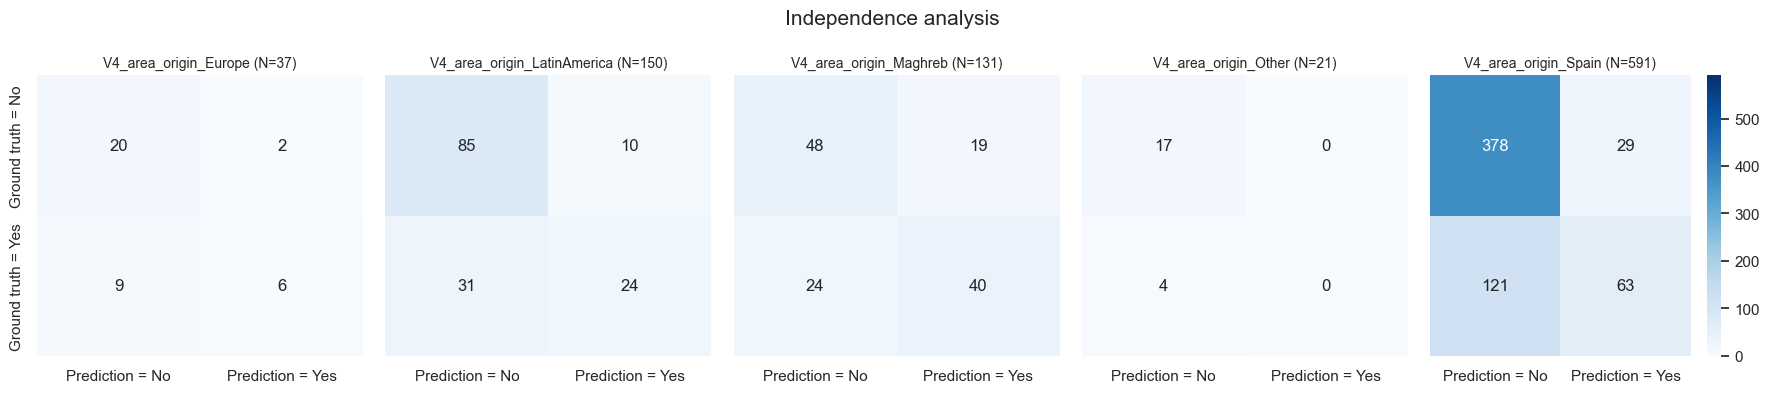

In [43]:
fig, accs = viz.plot_confusion_matrices(1, 5, figsize=(18, 4))
plt.tight_layout()
plt.show()

In [45]:
from pprint import pprint
# Accuracies
print("Accuracy:\n")
pprint(accs)

Accuracy:

{'V4_area_origin_Europe': 0.7027027027027027,
 'V4_area_origin_LatinAmerica': 0.7266666666666667,
 'V4_area_origin_Maghreb': 0.6717557251908397,
 'V4_area_origin_Other': 0.8095238095238095,
 'V4_area_origin_Spain': 0.7461928934010152}


### Separation 

Also known as *equalized odds*. Here the FPR and TPR across sensitive attributes should add up for which reason we exploit the ROC curves.

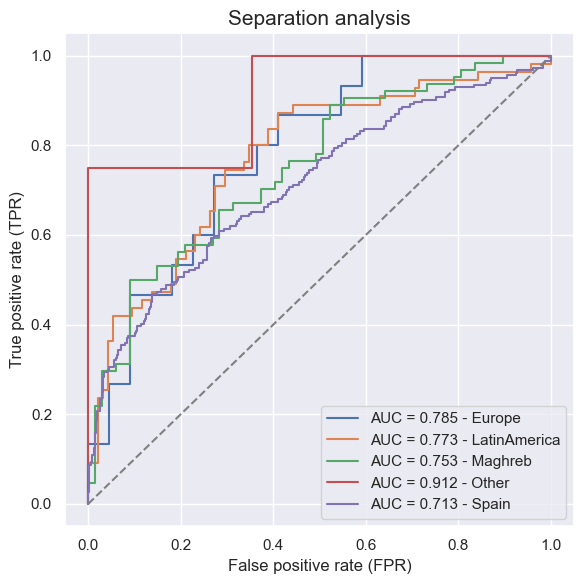

In [46]:
viz.plot_roc_curve(figsize=(6,6))
plt.tight_layout()
plt.show()

### Sufficiency

Can be considered by examining whether the model is well calibrated.

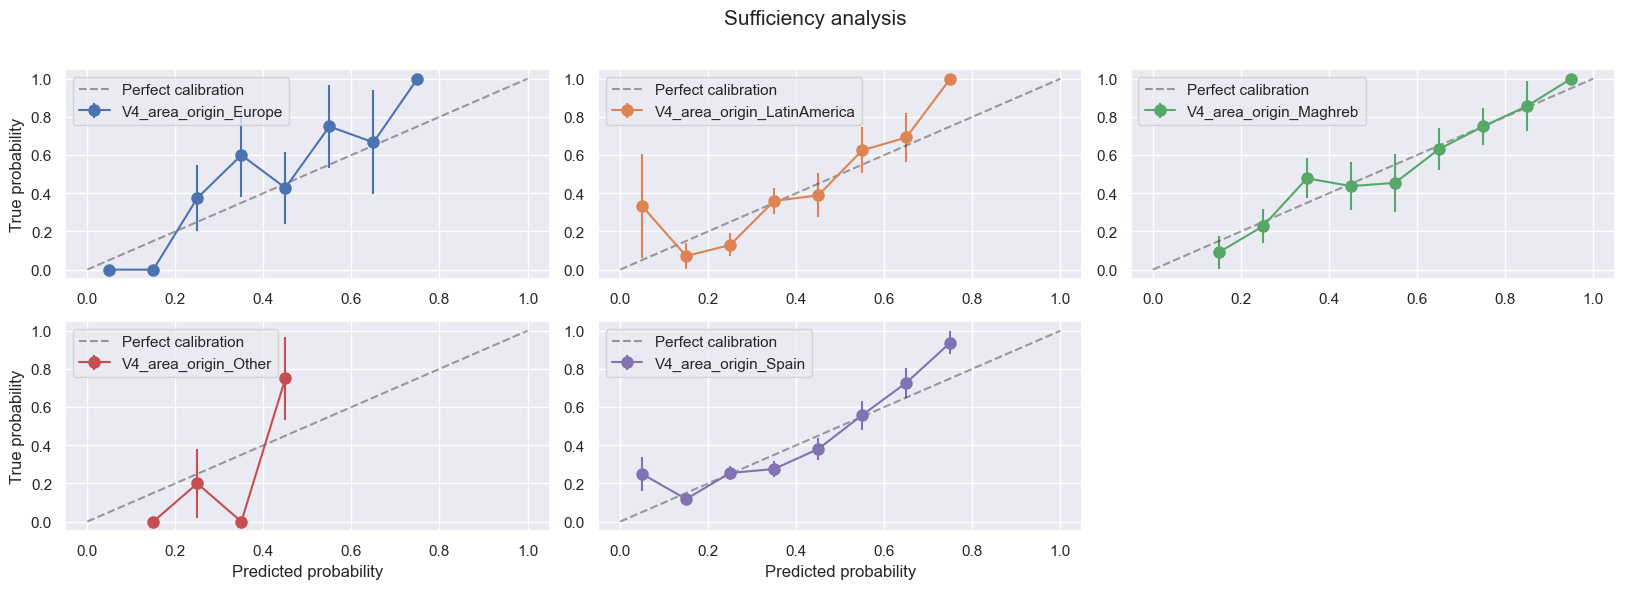

In [50]:
viz.plot_calibration_curves(2, 3, figsize=(20,6))
plt.show()

### Latent representations

Let's examine whether the model has learned a bias in its latent space...

In [51]:
latent_train_representations = []

with torch.no_grad():
    for batch in tqdm.tqdm(iter(train_loader)):
        inputs, labels = batch['data'].to(device), batch['label'].to(device)
        # Standardize input
        inputs = (inputs - mu) / sigma

        # Get latent representations of training set
        latent_train_representations.extend(model(inputs)['z'])

latent_train_representations = torch.stack(latent_train_representations).cpu().numpy()

100%|██████████| 47/47 [00:02<00:00, 17.78it/s]


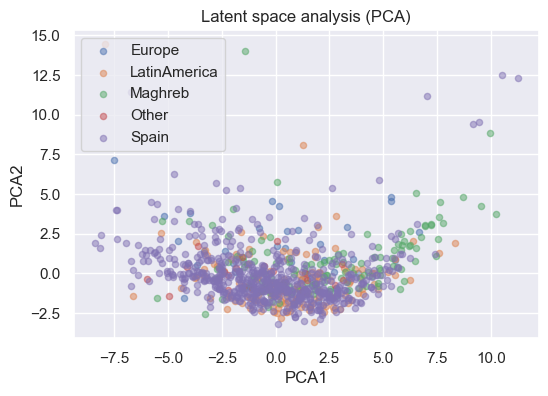

In [52]:
viz.plot_latent_representations(train_repr=latent_train_representations, test_repr=latent_test_representations, reduction_method='PCA', figsize=(6, 4))
plt.show()

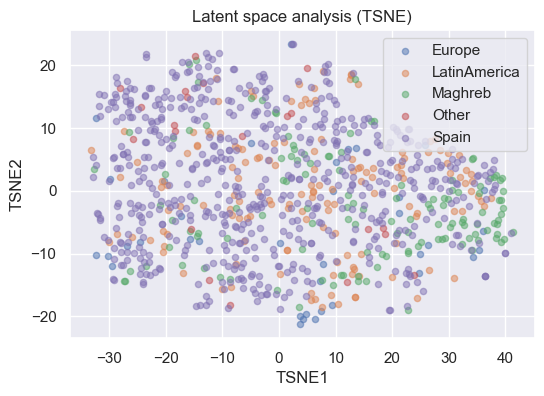

In [53]:
viz.plot_latent_representations(test_repr=latent_test_representations, reduction_method='TSNE', perplexity=40, figsize=(6, 4))
plt.show()

## Model trained without access to sensitive attributes

In [54]:
experiment_name = 'modelv1.0-AutoEncoder-no_sensitive_data.lr=1e-4'

#### Load experiment from training file

In [55]:
# Load experiment file
experiment = torch.load(f"{MODEL_DIR}/{experiment_name}/best.ckpt")

# Set random seed
set_seed(experiment['seed'])

# Load dataset
dataset = CatalanJuvenileJustice(
    data_path=f"{DATA_DIR}/processed/{experiment['data']['filename']}"
)

# Get test split
train_loader, _, test_loader = dataset.get_loaders(
    batch_size=experiment['training_parameters']['batch_size'], 
    shuffle=True, 
    num_workers=1, 
    test_size=experiment['data']['split']['test_proportion'], 
    val_size=experiment['data']['split']['val_proportion'], 
    split_type=experiment['data']['split']['split_type'],
)

# Load model in evaluation mode
model = load_model(experiment=experiment)
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=73, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=32, out_features=32, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

#### Predict on test data

In [56]:
mu      = experiment['data']['standardization']['mu']
sigma   = experiment['data']['standardization']['sigma']

sensitive_data = []
preds, pred_probs, gt_labels, equals = [], [], [], []
latent_representations = []

with torch.no_grad():
    for batch in tqdm.tqdm(iter(test_loader)):
        inputs, labels = batch['data'].to(device), batch['label'].to(device)
        sensitive_data.extend(batch['sensitive_data'])

        # Standardize input
        inputs = (inputs - mu) / sigma
        # Get predictions
        outputs = model(inputs)
        y_pred = outputs['pred']
        latent_representations.extend(outputs['z'])

        # Store predictions
        pred_probs.extend(y_pred)
        preds.extend(y_pred >= 0.5)

        # Store ground truth labels
        gt_labels.extend(labels)

preds, pred_probs, gt_labels = torch.stack(preds), torch.stack(pred_probs), torch.stack(gt_labels)
latent_representations = torch.stack(latent_representations)

100%|██████████| 15/15 [00:02<00:00,  6.09it/s]


In [57]:
df = pd.DataFrame(torch.stack(sensitive_data), columns=test_loader.dataset.dataset.sensitive_attributes)
df = df.rename(columns={'V4_area_origin_Latin America': 'V4_area_origin_LatinAmerica'})

df['labels'] = gt_labels.cpu()
df['pred_probs'] = pred_probs.cpu()
df['preds'] = preds.cpu().type(torch.int)

In [58]:
print(f"Mean predictor: {1 - df['labels'].mean()}")
print(f"Trained NN: \t{(df['labels'] == df['preds']).mean()}")

Mean predictor: 0.6537634408602151
Trained NN: 	0.7086021505376344


## Visualizations

Create visualization object

In [59]:
viz = FairnessVisualizer(df, biasAttribute=biasAttribute)

### Independence 

Probability of belonging to positive class must be equal across groups. For binary classification this means that probability of negative classes also should be equal.

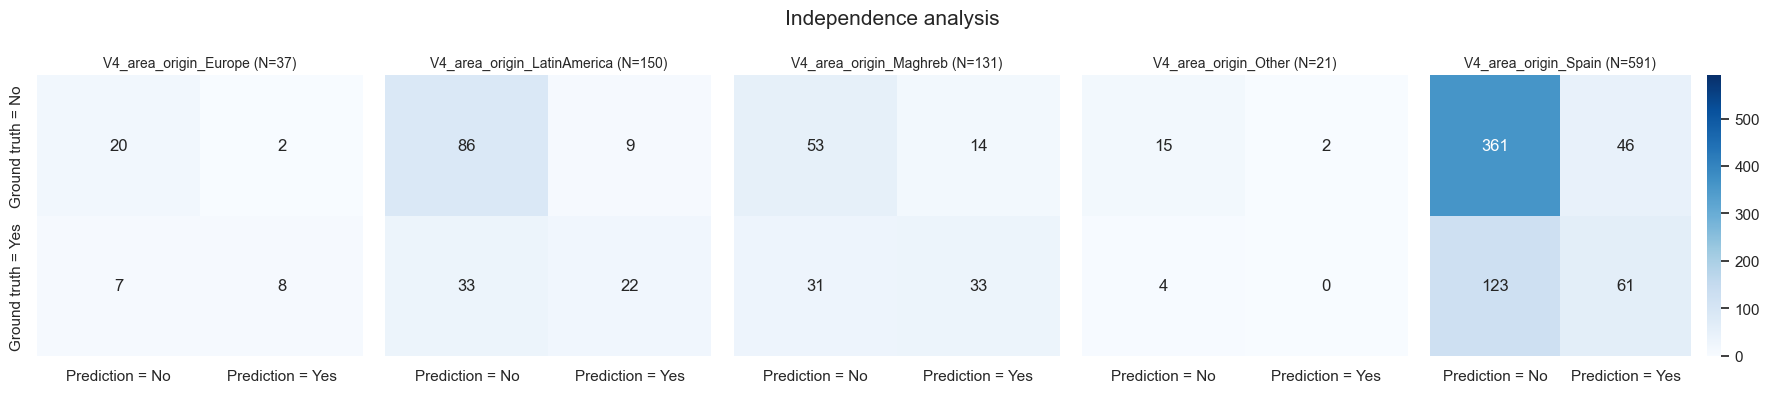

In [60]:
fig, accs = viz.plot_confusion_matrices(1, 5, figsize=(18, 4))
plt.tight_layout()
plt.show()

In [61]:
# Accuracies
print("Accuracy:\n")
pprint(accs)

Accuracy:

{'V4_area_origin_Europe': 0.7567567567567568,
 'V4_area_origin_LatinAmerica': 0.72,
 'V4_area_origin_Maghreb': 0.6564885496183206,
 'V4_area_origin_Other': 0.7142857142857143,
 'V4_area_origin_Spain': 0.7140439932318104}


### Separation 

Also known as *equalized odds*. Here the FPR and TPR across sensitive attributes should add up for which reason we exploit the ROC curves.

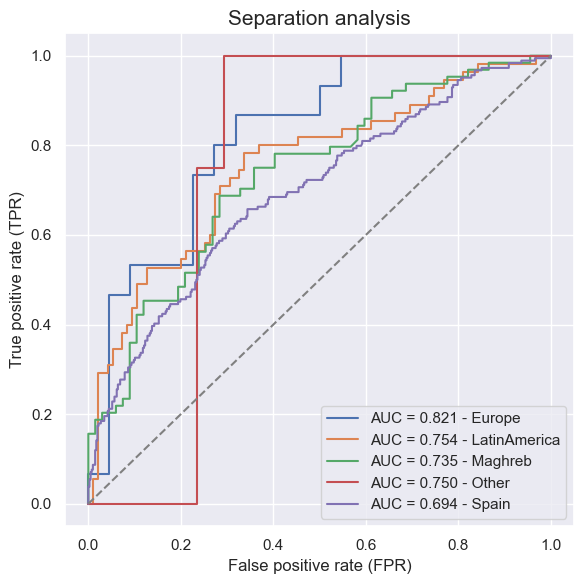

In [62]:
viz.plot_roc_curve(figsize=(6,6))
plt.tight_layout()
plt.show()

### Sufficiency

Can be considered by examining whether the model is well calibrated.

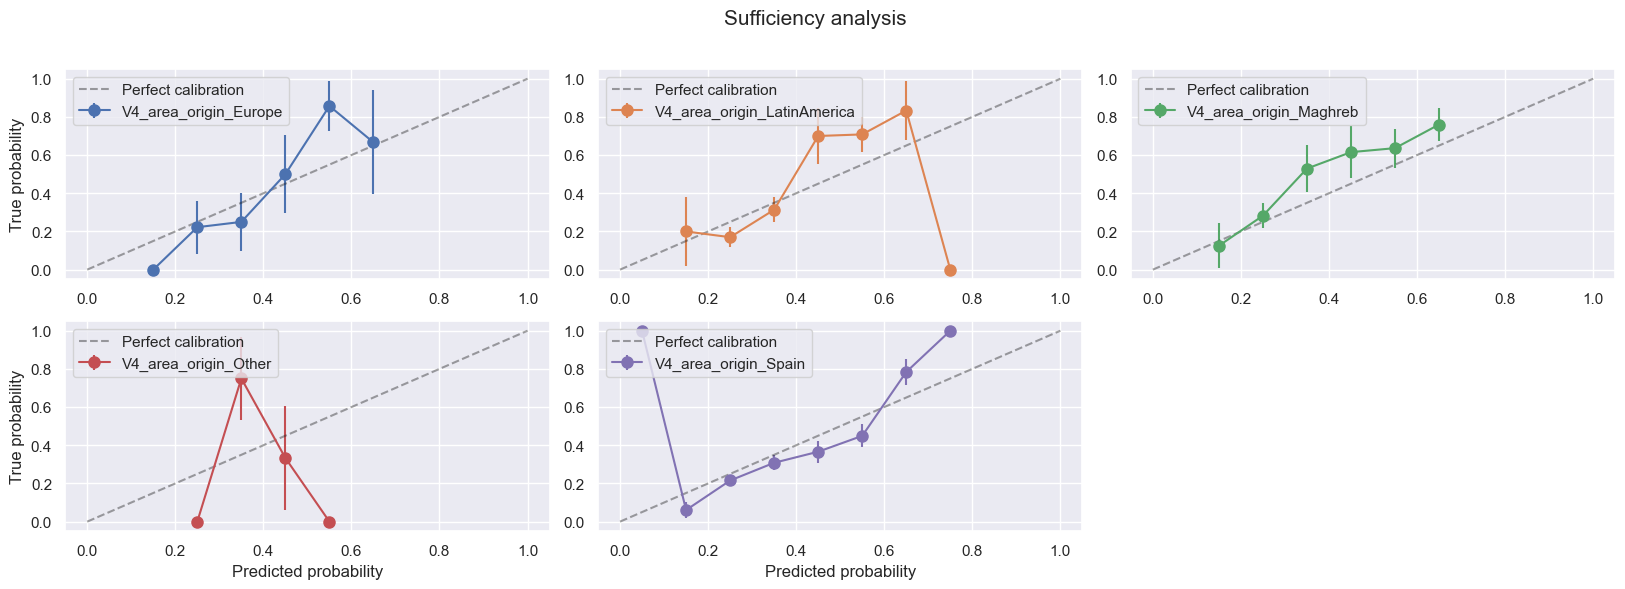

In [64]:
viz.plot_calibration_curves(2, 3, figsize=(20,6))
plt.show()

### Latent representations

Let's examine whether the model has learned a bias in its latent space...

In [65]:
latent_train_representations = []

with torch.no_grad():
    for batch in tqdm.tqdm(iter(train_loader)):
        inputs, labels = batch['data'].to(device), batch['label'].to(device)
        # Standardize input
        inputs = (inputs - mu) / sigma

        # Get latent representations of training set
        latent_train_representations.extend(model(inputs)['z'])

latent_train_representations = torch.stack(latent_train_representations).cpu().numpy()

100%|██████████| 47/47 [00:02<00:00, 18.47it/s]


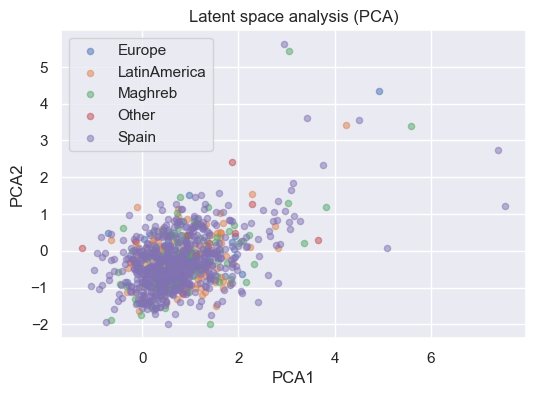

In [66]:
viz.plot_latent_representations(train_repr=latent_train_representations, test_repr=latent_test_representations, reduction_method='PCA', figsize=(6, 4))
plt.show()

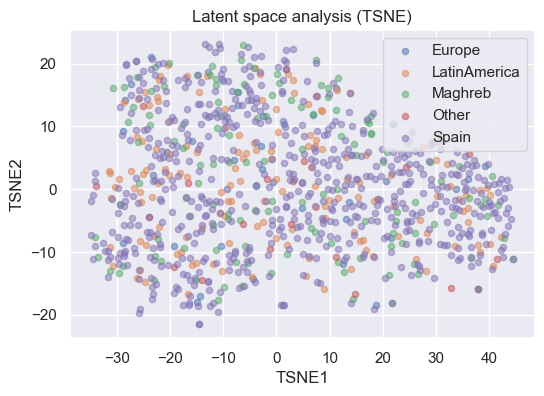

In [67]:
viz.plot_latent_representations(test_repr=latent_test_representations, reduction_method='TSNE', perplexity=40, figsize=(6, 4))
plt.show()